<a id='top'> </a>

In [1]:
%load_ext watermark
%watermark -a 'Author: James Bourbeau' -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

Author: James Bourbeau 
last updated: 2017-09-15 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.2
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.7.0


# Cosmic-ray composition spectrum analysis
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Fraction correctly identified](#Fraction-correctly-identified)
4. [Spectrum](#Spectrum)
5. [Unfolding](#Unfolding)

In [2]:
from __future__ import division, print_function
import os
from collections import defaultdict
import itertools
import numpy as np
from scipy import interp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns
import matplotlib as mpl
import pyprind

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold, StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import comptools as comp
import comptools.analysis.plotting as plotting
    
# color_dict allows for a consistent color-coding for each composition
color_dict = comp.analysis.get_color_dict()

%matplotlib inline

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Welcome to JupyROOT 6.09/02


# Define analysis free parameters
[ [back to top](#top) ]

Whether or not to train on 'light' and 'heavy' composition classes, or the individual compositions

In [3]:
comp_class = True
target = 'MC_comp_class' if comp_class else 'MC_comp'
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

Get composition classifier pipeline

In [4]:
pipeline_str = 'BDT'
pipeline = comp.get_pipeline(pipeline_str)

Define energy binning for this analysis

In [5]:
energybins = comp.analysis.get_energybins()

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [6]:
df_sim_train, df_sim_test = comp.load_sim(config='IC86.2012')
feature_list, feature_labels = comp.analysis.get_training_features()

In [7]:
feature_list

['lap_cos_zenith', 'log_s125', 'log_dEdX']

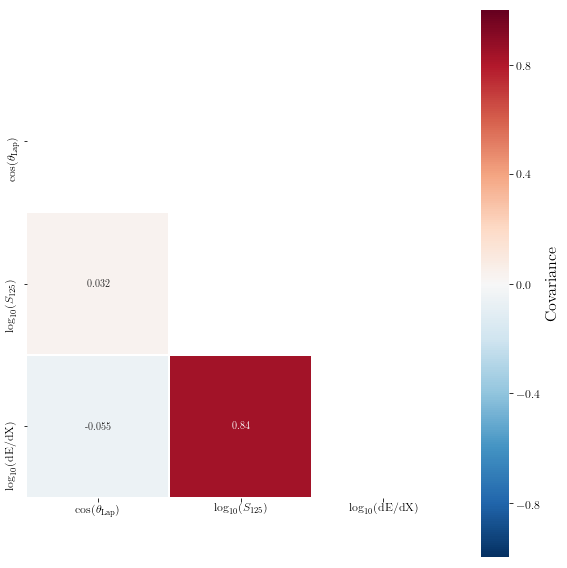

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:
/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [8]:
corr = df_sim_train[feature_list].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0,
            square=True, xticklabels=feature_labels, yticklabels=feature_labels,
            linewidths=.5, cbar_kws={'label': 'Covariance'}, annot=True, ax=ax)
# plt.savefig('/home/jbourbeau/public_html/figures/frac-correct-{}.png'.format(pipeline_str))

# outfile = os.path.join('/home/jbourbeau/public_html/figures', 'feature_covariance.png')
# plt.savefig(outfile)
plt.show()

In [9]:
# label_replacement = {feature: labels for feature, labels in zip(feature_list, feature_labels)}
# with plt.rc_context({'text.usetex': False}):
#     g = sns.pairplot(df_sim.sample(frac=1)[:2000], vars=feature_list, hue=target,
#                      plot_kws={'alpha': 0.25, 'linewidth': 0},
#                      diag_kws={'histtype': 'step', 'linewidth': 2, 'fill': True, 'alpha': 0.75, 'bins': 20})
#     # Replace axes labels
#     for i in range(len(feature_list)):
#         for j in range(len(feature_list)):
#             xlabel = g.axes[i][j].get_xlabel()
#             ylabel = g.axes[i][j].get_ylabel()
#             if xlabel in label_replacement.keys():
#                 g.axes[i][j].set_xlabel(label_replacement[xlabel])
#             if ylabel in label_replacement.keys():
#                 g.axes[i][j].set_ylabel(label_replacement[ylabel])
    
#     g.fig.get_children()[-1].set_title('Comp class')            
# #     g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

In [8]:
df_data = comp.load_data(config='IC86.2012')

/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:137: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:138: RuntimeWarning: divide by zero encountered in log10
  df['log_d4r_peak_energy'] = np.log10(df['d4r_peak_energy'])
/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:139: RuntimeWarning: divide by zero encountered in log10
  df['log_d4r_peak_sigma'] = np.log10(df['d4r_peak_sigma'])


In [11]:
# is_finite_mask = np.isfinite(data.X)
# not_finite_mask = np.logical_not(is_finite_mask)
# finite_data_mask = np.logical_not(np.any(not_finite_mask, axis=1))
# data = data[finite_data_mask]

Run classifier over training and testing sets to get an idea of the degree of overfitting

In [10]:
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
pipeline.fit(df_sim_train[feature_list], df_sim_train['target'])
# pipeline.fit(sim_train.X, sim_train.y, classifier__sample_weight=weights)
train_pred = pipeline.predict(df_sim_train[feature_list])
train_acc = accuracy_score(df_sim_train['target'], train_pred)
print('Training accuracy = {:.2%}'.format(train_acc))
test_pred = pipeline.predict(df_sim_test[feature_list])
test_acc = accuracy_score(df_sim_test['target'], test_pred)
print('Testing accuracy = {:.2%}'.format(test_acc))
print('=' * 30)

GradientBoostingClassifier
Training accuracy = 75.55%
Testing accuracy = 75.34%


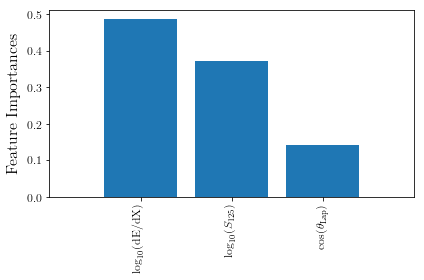

1) 0.487316041353
2) 0.37151777952
3) 0.141166179127


In [13]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
plt.show()

In [14]:
# classifier_score = pipeline.decision_function(df_sim_train[feature_list])
# light_mask = sim_train.labels == 'light'
# heavy_mask = sim_train.labels == 'heavy'
# fig, ax = plt.subplots()
# score_bins = np.linspace(-3, 3, 75)
# ax.hist(classifier_score[light_mask], bins=score_bins, label='light', alpha=0.75)
# ax.hist(classifier_score[heavy_mask], bins=score_bins, label='heavy', alpha=0.75)
# ax.set_xlim([-3, 3])
# ax.set_xlabel('BDT score')
# ax.set_ylabel('Counts')
# ax.grid()
# ax.legend()
# plt.show()

## Fraction correctly identified
[ [back to top](#top) ]

Calculate classifier performance via 10-fold CV

In [10]:
frac_correct_folds = comp.analysis.get_CV_frac_correct(sim_train, pipeline_str, comp_list)
frac_correct_gen_err = {key: np.std(frac_correct_folds[key], axis=0) for key in frac_correct_folds}

Using scikit-learn GradientBoostingClassifier...
Running 10 folds in parallel...
Completed fold 0
Completed fold 1
Completed fold 2
Completed fold 3
Completed fold 4
Completed fold 5
Completed fold 6
Completed fold 7
Completed fold 8
Completed fold 9


#### Plot fraction of events correctlty classified vs energy
This is done via 10-fold cross-validation. This will give an idea as to how much variation there is in the classifier due to different trainig and testing samples. 

light
heavy
total


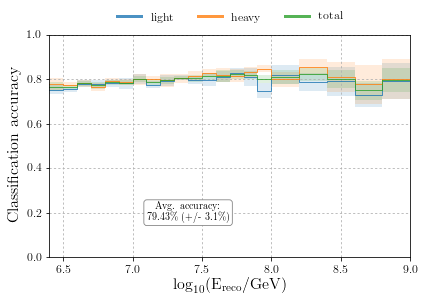

In [12]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    print(composition)
    performance_mean = np.mean(frac_correct_folds[composition], axis=0)
    performance_std = np.std(frac_correct_folds[composition], axis=0)
#     err = np.sqrt(frac_correct_gen_err[composition]**2 + reco_frac_stat_err[composition]**2)
    plotting.plot_steps(energybins.log_energy_bins, performance_mean, yerr=performance_std,
                        ax=ax, color=color_dict[composition], label=composition)
plt.xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('Classification accuracy')
# ax.set_ylabel('Classification accuracy \n (statistical + 10-fold CV error)')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
ax.grid()
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.15),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

cv_str = 'Avg. accuracy:\n{:0.2f}\% (+/- {:0.1f}\%)'.format(np.mean(frac_correct_folds['total'])*100,
                                                      np.std(frac_correct_folds['total'])*100)
ax.text(7.4, 0.2, cv_str,
        ha="center", va="center", size=10,
        bbox=dict(boxstyle='round', fc="white", ec="gray", lw=0.8))
plt.savefig('/home/jbourbeau/public_html/figures/frac-correct-{}.png'.format(pipeline_str))
plt.show()

Determine the mean and standard deviation of the fraction correctly classified for each energy bin

In [10]:
avg_frac_correct_data = {'values': np.mean(frac_correct_folds['total'], axis=0), 'errors': np.std(frac_correct_folds['total'], axis=0)}
avg_frac_correct, avg_frac_correct_err = comp.analysis.averaging_error(**avg_frac_correct_data)

In [11]:
reco_frac, reco_frac_stat_err = comp.analysis.get_frac_correct(sim_train, sim_test, pipeline, comp_list)

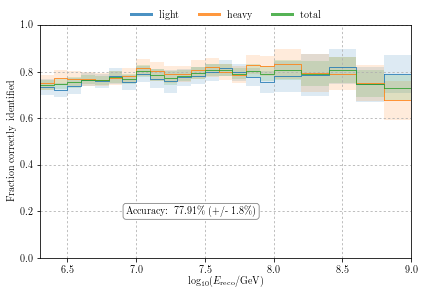

In [13]:
# Plot fraction of events correctlt classified vs energy
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    err = np.sqrt(frac_correct_gen_err[composition]**2 + reco_frac_stat_err[composition]**2)
    plotting.plot_steps(energybins.log_energy_bins, reco_frac[composition], err, ax,
                        color_dict[composition], composition)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction correctly identified')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
ax.grid()
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

cv_str = 'Accuracy: {:0.2f}\% (+/- {:0.1f}\%)'.format(avg_frac_correct*100, avg_frac_correct_err*100)
ax.text(7.4, 0.2, cv_str,
        ha="center", va="center", size=10,
        bbox=dict(boxstyle='round', fc="white", ec="gray", lw=0.8))
plt.savefig('/home/jbourbeau/public_html/figures/frac-correct-{}.png'.format(pipeline_str))
plt.show()

## Spectrum
[ [back to top](#top) ]

In [11]:
# energy_bins = 10**np.arange(6.3, 9.01, 0.1)
# energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2

In [9]:
light_mask = df_sim_train['MC_comp_class'] == 'light'
heavy_mask = df_sim_train['MC_comp_class'] == 'heavy'

In [10]:
X_data = comp.dataframe_functions.dataframe_to_array(df_data, feature_list + ['lap_log_energy'])

In [11]:
log_energy = X_data[:,-1]
X_data = X_data[:,:-1]

In [12]:
pipeline.fit(df_sim_train[feature_list], df_sim_train['target'])
data_predictions = pipeline.predict(X_data)

In [13]:
data_predictions

array([1, 0, 1, ..., 0, 1, 1])

In [14]:
data_labels = np.array([comp.dataframe_functions.label_to_comp(pred) for pred in data_predictions])
data_labels

array(['heavy', 'light', 'heavy', ..., 'light', 'heavy', 'heavy'], 
      dtype='|S5')

In [15]:
data_light_mask = data_labels == 'light'
data_heavy_mask = data_labels == 'heavy'

Get the number of events per energy bin for each composition

In [16]:
# num_particles, num_particles_err = comp.analysis.get_num_particles(df_sim_train, df_data, pipeline, comp_list)
# num_particles

In [17]:
# Get number of identified comp in each energy bin
num_particles, num_particles_err = {}, {}
for composition in comp_list:
    comp_mask = data_labels == composition
    num_particles[composition] = np.histogram(log_energy[comp_mask], bins=energybins.log_energy_bins)[0]
    num_particles_err[composition] = np.sqrt(num_particles[composition])

num_particles['total'] = np.histogram(log_energy, bins=energybins.log_energy_bins)[0]
num_particles_err['total'] = np.sqrt(num_particles['total'])

In [18]:
num_particles

{'heavy': array([233037, 145728,  99038,  66484,  40849,  29647,  19869,  12063,
          7940,   5442,   3558,   2722,   1886,   1134,    758,    559]),
 'light': array([360613, 256442, 164393, 102273,  64793,  35326,  20067,  12687,
          7543,   4464,   2778,   1423,    715,    493,    298,    144]),
 'total': array([593650, 402170, 263431, 168757, 105642,  64973,  39936,  24750,
         15483,   9906,   6336,   4145,   2601,   1627,   1056,    703])}

In [19]:
df_counts = pd.DataFrame()
for composition in num_particles.keys():
    df_counts['counts_obs_' + composition] = num_particles[composition]
    df_counts['counts_obs_err_' + composition] = np.sqrt(num_particles[composition])

In [20]:
df_counts

,counts_obs_heavy,counts_obs_err_heavy,counts_obs_light,counts_obs_err_light,counts_obs_total,counts_obs_err_total
0,233037,482.739060,360613,600.510616,593650,770.486859
1,145728,381.743369,256442,506.401027,402170,634.168747
2,99038,314.703035,164393,405.454066,263431,513.255297
3,66484,257.844915,102273,319.801501,168757,410.800438
4,40849,202.111355,64793,254.544692,105642,325.026153
5,29647,172.183042,35326,187.952122,64973,254.898019
6,19869,140.957440,20067,141.658039,39936,199.839936
7,12063,109.831689,12687,112.636584,24750,157.321327
8,7940,89.106678,7543,86.850446,15483,124.430704
9,5442,73.769913,4464,66.813172,9906,99.528890


In [33]:
model_name = 'h3a'

In [34]:
df_unfolded_counts = pd.read_hdf('unfolding/PyUnfold/unfolded_output_{}.hdf'.format(model_name), 'counts', mode='r')
df_unfolded_stat_err = pd.read_hdf('unfolding/PyUnfold/unfolded_output_{}.hdf'.format(model_name), 'stat_err', mode='r')
df_unfolded_sys_err = pd.read_hdf('unfolding/PyUnfold/unfolded_output_{}.hdf'.format(model_name), 'sys_err', mode='r')

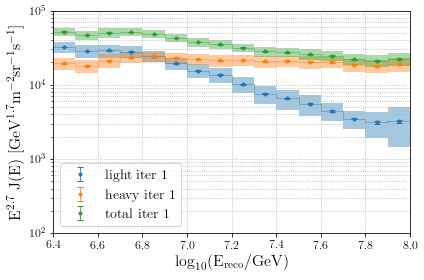

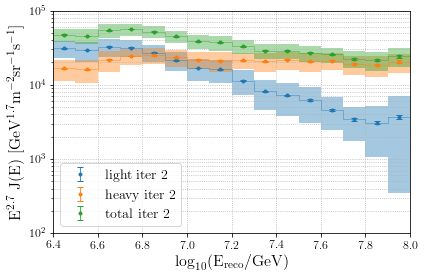

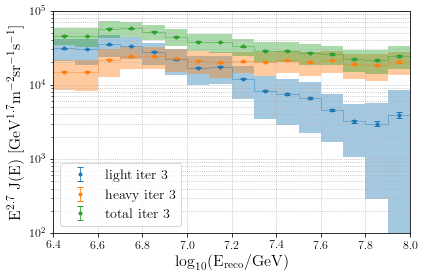

In [35]:
for idx_iter in df_unfolded_counts.columns:
    fig, ax = plt.subplots()
    
    color_dict_iter = {}
    color_dict_iter['light'] = sns.color_palette('Blues', len(df_unfolded_counts.columns)).as_hex()[idx_iter-1]
    color_dict_iter['heavy'] = sns.color_palette('Oranges', len(df_unfolded_counts.columns)).as_hex()[idx_iter-1]
    color_dict_iter['total'] = sns.color_palette('Greens', len(df_unfolded_counts.columns)).as_hex()[idx_iter-1]
    
    df_iter_counts = df_unfolded_counts[idx_iter]
    counts = {}
    counts['light'] = df_iter_counts[::2].values
    counts['heavy'] = df_iter_counts[1::2].values
    counts['total'] = counts['light'] + counts['heavy']
    
    df_iter_sys_err = df_unfolded_sys_err[idx_iter]
    counts_sys_err = {}
    counts_sys_err['light'] = df_iter_sys_err[::2].values
    counts_sys_err['heavy'] = df_iter_sys_err[1::2].values
    counts_sys_err['total'] = np.sqrt(counts_sys_err['light']**2 + counts_sys_err['heavy']**2)
    
    df_iter_stat_err = df_unfolded_stat_err[idx_iter]
    counts_stat_err = {}
    counts_stat_err['light'] = df_iter_stat_err[::2].values
    counts_stat_err['heavy'] = df_iter_stat_err[1::2].values
    counts_stat_err['total'] = np.sqrt(counts_stat_err['light']**2 + counts_stat_err['heavy']**2)
    
    for composition in comp_list + ['total']:    
        flux, flux_err_sys = comp.analysis.get_flux(counts[composition], counts_sys_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=eff_area, 
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
        flux, flux_err_stat = comp.analysis.get_flux(counts[composition], counts_stat_err[composition],
                                                     energybins=energybins.energy_bins,
                                                     eff_area=eff_area, 
                                                     livetime=livetime, livetime_err=livetime_err, 
                                                     solid_angle=solid_angle)
        
        plotting.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err_sys,
                            ax=ax, alpha=0.4, fillalpha=0.4,  
                            color=color_dict[composition])
        ax.errorbar(energybins.log_energy_midpoints, flux, yerr=flux_err_stat,  
                    color=color_dict[composition], ls='None', marker='.', 
                    label=composition + ' iter {}'.format(idx_iter))

    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
    ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
    ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
    ax.set_ylim([10**2, 10**5])
    ax.grid(linestyle='dotted', which="both")
    ax.legend()
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    iter_unfold_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'iter-bayesian', 
                                       'flux_{}_iter_{}.png'.format(model_name, idx_iter))
    plt.savefig(iter_unfold_outfile)
    plt.show()

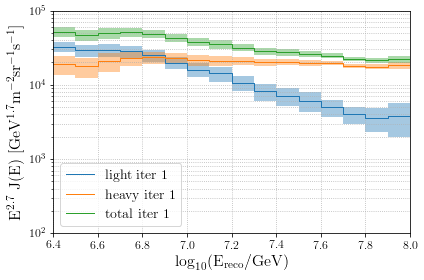

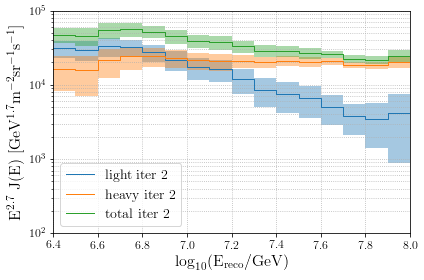

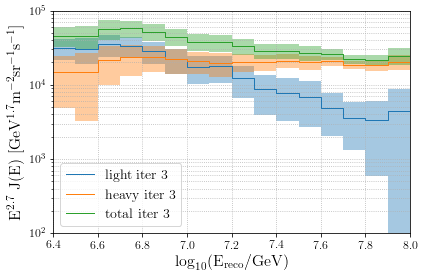

In [41]:
for idx_iter in df_unfolded_counts.columns:
    fig, ax = plt.subplots()
    
    color_dict_iter = {}
    color_dict_iter['light'] = sns.color_palette('Blues', len(df_unfolded_counts.columns)).as_hex()[idx_iter-1]
    color_dict_iter['heavy'] = sns.color_palette('Oranges', len(df_unfolded_counts.columns)).as_hex()[idx_iter-1]
    color_dict_iter['total'] = sns.color_palette('Greens', len(df_unfolded_counts.columns)).as_hex()[idx_iter-1]
    
    df_iter_counts = df_unfolded_counts[idx_iter]
    counts = {}
    counts['light'] = df_iter_counts[::2].values
    counts['heavy'] = df_iter_counts[1::2].values
    counts['total'] = counts['light'] + counts['heavy']
    
    df_iter_stat_err = df_unfolded_stat_err[idx_iter]
    df_iter_sys_err = df_unfolded_sys_err[idx_iter]
    counts_err = {}
    sys_err_light = df_iter_sys_err[::2].values
    sys_err_heavy = df_iter_sys_err[1::2].values
    stat_err_light = df_iter_stat_err[::2].values
    stat_err_heavy = df_iter_stat_err[1::2].values
    counts_err['light'] = np.sqrt(sys_err_light**2 + stat_err_light**2)
    counts_err['heavy'] = np.sqrt(sys_err_light**2 + stat_err_light**2)
    counts_err['total'] = np.sqrt(counts_err['light']**2 + counts_err['heavy']**2)
    
    for composition in comp_list + ['total']:    
        flux, flux_err = comp.analysis.get_flux(counts[composition], counts_err[composition],
                                            energybins=energybins.energy_bins,
                                            eff_area=eff_area, 
                                            livetime=livetime, livetime_err=livetime_err, 
                                            solid_angle=solid_angle)
        plotting.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err,
                            ax=ax, fillalpha=0.4,  
                            color=color_dict[composition], label=composition + ' iter {}'.format(idx_iter))
        plotting.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err,
                            ax=ax, fillalpha=0.4,  
                            color=color_dict[composition], label=composition + ' iter {}'.format(idx_iter))

    ax.set_yscale("log", nonposy='clip')
    ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
    ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
    ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
    ax.set_ylim([10**2, 10**5])
    ax.grid(linestyle='dotted', which="both")
    ax.legend()
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    iter_unfold_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'iter-bayesian', 
                                       'flux_{}_iter_{}.png'.format(model_name, idx_iter))
    plt.savefig(iter_unfold_outfile)
    plt.show()

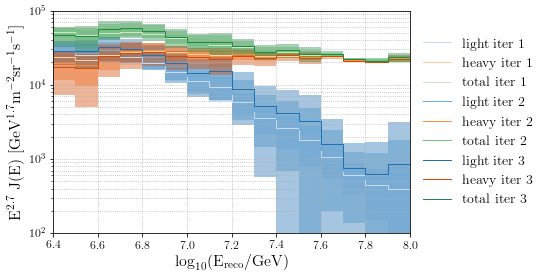

In [37]:
fig, ax = plt.subplots()
for idx_iter in df_unfolded_counts.columns:    
    color_dict_iter = {}
    color_dict_iter['light'] = sns.color_palette('Blues', len(df_unfolded_counts.columns)).as_hex()[idx_iter-1]
    color_dict_iter['heavy'] = sns.color_palette('Oranges', len(df_unfolded_counts.columns)).as_hex()[idx_iter-1]
    color_dict_iter['total'] = sns.color_palette('Greens', len(df_unfolded_counts.columns)).as_hex()[idx_iter-1]
    
    df_iter_counts = df_unfolded_counts[idx_iter]
    counts = {}
    counts['light'] = df_iter_counts[::2].values
    counts['heavy'] = df_iter_counts[1::2].values
    counts['total'] = counts['light'] + counts['heavy']
    
    df_iter_stat_err = df_unfolded_stat_err[idx_iter]
    df_iter_sys_err = df_unfolded_sys_err[idx_iter]
    counts_err = {}
    sys_err_light = df_iter_sys_err[::2].values
    sys_err_heavy = df_iter_sys_err[1::2].values
    stat_err_light = df_iter_stat_err[::2].values
    stat_err_heavy = df_iter_stat_err[1::2].values
    counts_err['light'] = np.sqrt(sys_err_light**2 + stat_err_light**2)
    counts_err['heavy'] = np.sqrt(sys_err_light**2 + stat_err_light**2)
    counts_err['total'] = np.sqrt(counts_err['light']**2 + counts_err['heavy']**2)
    
    for composition in comp_list + ['total']:    
        flux, flux_err = comp.analysis.get_flux(counts[composition], counts_err[composition],
                                            energybins=energybins.energy_bins,
                                            eff_area=eff_area, 
                                            livetime=livetime, livetime_err=livetime_err, 
                                            solid_angle=solid_angle)
        plotting.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err,
                            ax=ax, fillalpha=0.4, 
                            color=color_dict_iter[composition], label=composition + ' iter {}'.format(idx_iter))

ax.set_yscale("log", nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
ax.set_ylim([10**2, 10**5])
ax.grid(linestyle='dotted', which="both")
# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
iter_unfold_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'iter-bayesian', 
                                       'flux_{}_iter_compare.png'.format(model_name))
plt.savefig(iter_unfold_outfile)
plt.show()

In [78]:
_, _, counts_unf, _ = comp.get1d('unfolding/PyUnfold/unfolded_output_{}.root'.format(model_name),
                                 'NC', 'Unf_ks_ACM/bin0')
counts_unf

array([  3.27947219e+05,   1.98483656e+05,   2.20279891e+05,
         1.30347141e+05,   1.71705203e+05,   1.28135156e+05,
         1.09639125e+05,   9.75781484e+04,   6.21004023e+04,
         6.72734531e+04,   3.24969785e+04,   4.12555820e+04,
         1.64247520e+04,   2.69419590e+04,   1.17764365e+04,
         1.72200996e+04,   4.65452197e+03,   1.28750684e+04,
         1.83507178e+03,   8.14455322e+03,   1.01998370e+03,
         6.09598877e+03,   5.39666138e+02,   3.84456714e+03,
         1.77686172e+02,   2.73301562e+03,   5.86329498e+01,
         1.63492688e+03,   3.34201088e+01,   1.07739038e+03,
         3.04622517e+01,   8.05836853e+02])

In [79]:
df_counts['counts_unf_light'] = counts_unf[::2]
df_counts['counts_unf_heavy'] = counts_unf[1::2]
df_counts['counts_unf_total'] = df_counts['counts_unf_light'] + df_counts['counts_unf_heavy']
df_counts

,counts_obs_heavy,counts_obs_err_heavy,counts_obs_light,counts_obs_err_light,counts_obs_total,counts_obs_err_total,counts_unf_light,counts_unf_heavy,counts_unf_total,counts_unf_err_light,counts_unf_err_heavy,counts_unf_err_total
0,233037,482.739060,360613,600.510616,593650,770.486859,327947.218750,198483.656250,526430.875000,113328.873221,71703.866360,134107.710279
1,145728,381.743369,256442,506.401027,402170,634.168747,220279.890625,130347.140625,350627.031250,90060.400805,52011.391899,104000.291732
2,99038,314.703035,164393,405.454066,263431,513.255297,171705.203125,128135.156250,299840.359375,62131.229287,47093.049796,77961.817525
3,66484,257.844915,102273,319.801501,168757,410.800438,109639.125000,97578.148438,207217.273438,38674.926781,27464.585651,47434.728064
4,40849,202.111355,64793,254.544692,105642,325.026153,62100.402344,67273.453125,129373.855469,22505.462869,18740.269257,29286.405563
5,29647,172.183042,35326,187.952122,64973,254.898019,32496.978516,41255.582031,73752.560547,13863.618835,12873.877677,18919.213875
6,19869,140.957440,20067,141.658039,39936,199.839936,16424.751953,26941.958984,43366.710938,7963.894078,7926.503802,11236.239202
7,12063,109.831689,12687,112.636584,24750,157.321327,11776.436523,17220.099609,28996.536133,5458.269344,5831.730817,7987.602178
8,7940,89.106678,7543,86.850446,15483,124.430704,4654.521973,12875.068359,17529.590332,2967.242899,3375.316555,4494.139770
9,5442,73.769913,4464,66.813172,9906,99.528890,1835.071777,8144.553223,9979.625000,1720.741112,2491.809593,3028.211522


In [80]:
_, _, err_stat, _ = comp.get1d('unfolding/PyUnfold/unfolded_output_{}.root'.format(model_name),
                               'NC_errStat', 'Unf_ks_ACM/bin0')
err_stat

array([ 570.17724609,  348.09909058,  399.85910034,  251.94061279,
        385.86950684,  310.27090454,  324.30990601,  263.4418335 ,
        247.50801086,  230.33055115,  181.37838745,  192.21238708,
        126.23529053,  155.14164734,  119.62017822,  130.32421875,
         62.04893112,  109.71964264,   36.50301743,   92.98684692,
         26.99246597,   83.09977722,   19.41142464,   68.15979004,
          7.64184761,   58.50258255,    3.16333556,   45.06313324,
          2.8863523 ,   37.84017563,    3.8011198 ,   31.85546684])

In [81]:
_, _, err_sys, _ = comp.get1d('unfolding/PyUnfold/unfolded_output_{}.root'.format(model_name),
                              'NC_errSys', 'Unf_ks_ACM/bin0')
err_sys

array([  1.16298148e+05,   9.17978281e+04,   9.16796562e+04,
         6.01725938e+04,   6.16700312e+04,   5.25455195e+04,
         3.88458516e+04,   3.26897891e+04,   2.32543750e+04,
         2.27959922e+04,   1.45965605e+04,   1.53457617e+04,
         8.65765625e+03,   1.03188467e+04,   6.87316309e+03,
         7.70947021e+03,   3.15855933e+03,   4.59243994e+03,
         1.62999622e+03,   3.17675513e+03,   1.05932837e+03,
         2.20700635e+03,   6.81626587e+02,   1.51476489e+03,
         2.07983032e+02,   9.43488342e+02,   6.67683945e+01,
         6.32076721e+02,   5.60453224e+01,   4.61299316e+02,
         8.11236038e+01,   2.77106445e+02])

In [82]:
df_counts['counts_unf_err_light'] = np.sqrt(err_sys[::2]**2 + err_stat[::2]**2)
df_counts['counts_unf_err_heavy'] = np.sqrt(err_sys[1::2]**2 + err_stat[1::2]**2)
df_counts['counts_unf_err_total'] = np.sqrt(df_counts['counts_unf_err_heavy']**2 + df_counts['counts_unf_err_light']**2)
df_counts

,counts_obs_heavy,counts_obs_err_heavy,counts_obs_light,counts_obs_err_light,counts_obs_total,counts_obs_err_total,counts_unf_light,counts_unf_heavy,counts_unf_total,counts_unf_err_light,counts_unf_err_heavy,counts_unf_err_total
0,233037,482.739060,360613,600.510616,593650,770.486859,327947.218750,198483.656250,526430.875000,116299.546139,91798.488122,148163.918865
1,145728,381.743369,256442,506.401027,402170,634.168747,220279.890625,130347.140625,350627.031250,91680.528235,60173.121181,109663.684828
2,99038,314.703035,164393,405.454066,263431,513.255297,171705.203125,128135.156250,299840.359375,61671.238431,52546.435567,81021.414086
3,66484,257.844915,102273,319.801501,168757,410.800438,109639.125000,97578.148438,207217.273438,38847.205312,32690.850563,50772.010706
4,40849,202.111355,64793,254.544692,105642,325.026153,62100.402344,67273.453125,129373.855469,23255.692139,22797.155787,32565.895179
5,29647,172.183042,35326,187.952122,64973,254.898019,32496.978516,41255.582031,73752.560547,14597.687417,15346.965444,21180.694659
6,19869,140.957440,20067,141.658039,39936,199.839936,16424.751953,26941.958984,43366.710938,8658.576505,10320.012874,13471.214230
7,12063,109.831689,12687,112.636584,24750,157.321327,11776.436523,17220.099609,28996.536133,6874.203939,7710.571665,10329.936843
8,7940,89.106678,7543,86.850446,15483,124.430704,4654.521973,12875.068359,17529.590332,3159.168734,4593.750430,5575.203144
9,5442,73.769913,4464,66.813172,9906,99.528890,1835.071777,8144.553223,9979.625000,1630.404899,3178.115745,3571.923827


In [24]:
# Solid angle
max_zenith_rad = df_sim_train['lap_zenith'].max()
solid_angle = 2*np.pi*(1-np.cos(max_zenith_rad))

In [25]:
# df_sim = comp.load_dataframe(datatype='sim', config='IC79')

In [26]:
livetime, livetime_err = comp.get_detector_livetime(config='IC86.2012')
livetime, livetime_err

(28439902.297499999, 2698.9896687099999)

In [27]:
eff_area = comp.get_effective_area_fit(config='IC86.2012', energy_points=energybins.energy_midpoints)
eff_area

array([ 134297.88809118,  135680.01126912,  136733.12312222,
        137727.31179083,  138710.9843124 ,  139692.78122725,
        140674.24367132,  141655.64647444,  142637.03864329,
        143618.4289161 ,  144599.81885086,  145581.20872536,
        146562.59858912,  147543.98845096,  148525.37831245,
        149506.76817389])

num_ptypes = 4
simlist = [12360 12362 12630 12631]
complist = ['PPlus', 'Fe56Nucleus', 'He4Nucleus', 'O16Nucleus']


num_ptypes = 2
simlist = [12360 12630]
complist = ['PPlus', 'He4Nucleus']


num_ptypes = 2
simlist = [12362 12631]
complist = ['Fe56Nucleus', 'O16Nucleus']




In [34]:
# # Live-time information
# goodrunlist = pd.read_table('/data/ana/CosmicRay/IceTop_GRL/IC79_2010_GoodRunInfo_4IceTop.txt', skiprows=[0, 3])
# goodrunlist.head()

In [35]:
# livetimes = goodrunlist['LiveTime(s)']
# livetime = np.sum(livetimes[goodrunlist['Good_it_L2'] == 1])
# print('livetime (seconds) = {}'.format(livetime))
# print('livetime (days) = {}'.format(livetime/(24*60*60)))

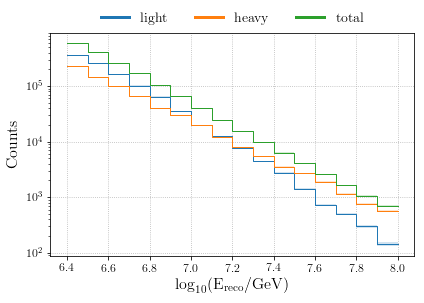

In [89]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    # Calculate dN/dE
    y = num_particles[composition]
    y_err = num_particles_err[composition]

    plotting.plot_steps(energybins.log_energy_bins, y, yerr=y_err,
                        ax=ax, color=color_dict[composition], label=composition)
ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('Counts')
# ax.set_xlim([6.3, 8.0])
# ax.set_ylim([10**-6, 10**-1])
ax.grid(linestyle=':')
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.15),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

# plt.savefig('/home/jbourbeau/public_html/figures/num_particles.png')
plt.show()

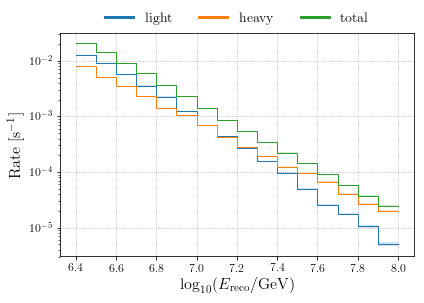

In [90]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    # Calculate dN/dE
    y = num_particles[composition]
    y_err = num_particles_err[composition]
    # Add time duration
#     y = y / livetime
#     y_err = y / livetime
    y, y_err = comp.analysis.ratio_error(y, y_err, livetime, livetime_err)
    plotting.plot_steps(energybins.log_energy_bins, y, yerr=y_err,
                        ax=ax, color=color_dict[composition], label=composition)
ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Rate [s$^{-1}$]')
# ax.set_xlim([6.3, 8.0])
# ax.set_ylim([10**-6, 10**-1])
ax.grid(linestyle=':')
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.15),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

# plt.savefig('/home/jbourbeau/public_html/figures/rate.png')
plt.show()

Calculate flux from given number of counts

In [91]:
df_flux = pd.DataFrame()
# Get observed flux
for composition in comp_list + ['total']:
    counts = df_counts['counts_obs_{}'.format(composition)]
    counts_err = df_counts['counts_obs_err_{}'.format(composition)]
    flux, flux_err = comp.analysis.get_flux(counts, counts_err,
                                            energybins=energybins.energy_bins,
                                            eff_area=eff_area, 
                                            livetime=livetime, livetime_err=livetime_err, 
                                            solid_angle=solid_angle)
    df_flux['flux_obs_{}'.format(composition)] = flux
    df_flux['flux_obs_{}_err'.format(composition)] = flux_err
    
# Get unfolded flux
for composition in comp_list + ['total']:
    counts = df_counts['counts_unf_{}'.format(composition)]
    counts_err = df_counts['counts_unf_err_{}'.format(composition)]
    flux, flux_err = comp.analysis.get_flux(counts, counts_err,
                                            energybins=energybins.energy_bins,
                                            eff_area=eff_area, 
                                            livetime=livetime, livetime_err=livetime_err, 
                                            solid_angle=solid_angle)
    df_flux['flux_unf_{}'.format(composition)] = flux
    df_flux['flux_unf_{}_err'.format(composition)] = flux_err
    
df_flux

,flux_obs_light,flux_obs_light_err,flux_obs_heavy,flux_obs_heavy_err,flux_obs_total,flux_obs_total_err,flux_unf_light,flux_unf_light_err,flux_unf_heavy,flux_unf_heavy_err,flux_unf_total,flux_unf_total_err
0,31714.700041,321.528350,20494.820080,209.308381,52209.520120,526.497484,28841.854486,10232.219827,17455.969754,8075.255253,46297.824240,13038.741180
1,33018.831259,336.579208,18763.573212,193.974972,51782.404471,524.245423,28362.688398,11807.962925,16783.172185,7749.558492,45145.860583,14127.238124
2,31066.905746,319.992131,18716.151000,196.391330,49783.056746,507.213536,32448.762184,11659.116082,24214.916828,9933.150984,56663.679011,15321.868008
3,28381.107394,297.374906,18449.537453,197.892442,46830.644847,482.002433,30425.232282,10784.525391,27078.270023,9075.863601,57503.502305,14101.137379
4,26406.184159,283.719393,16647.881973,185.748447,43054.066132,450.475865,25308.824420,9481.163322,27417.085059,9294.954237,52725.909478,13282.598524
5,21145.059573,239.524874,17745.784441,205.222330,38890.844014,417.782554,19451.694125,8739.892806,24694.325419,9189.541425,44146.019544,12685.798194
6,17642.343528,215.959916,17468.267482,214.183090,35110.611009,392.625607,14440.181209,7613.747197,23686.614627,9076.157473,38126.795836,11849.649566
7,16383.755640,219.095503,15577.933656,210.680898,31961.689296,378.733269,15207.870916,8878.521686,22237.716095,9959.771821,37445.587011,13345.143154
8,14308.700933,218.216956,15061.790456,226.405110,29370.491389,376.808608,8829.399827,5993.438553,24423.373014,8717.541441,33252.772841,10581.113699
9,12439.485749,223.918809,15164.803191,255.456040,27604.288940,391.317378,5113.653500,4543.611833,22695.800570,8859.118824,27809.454069,9957.490076


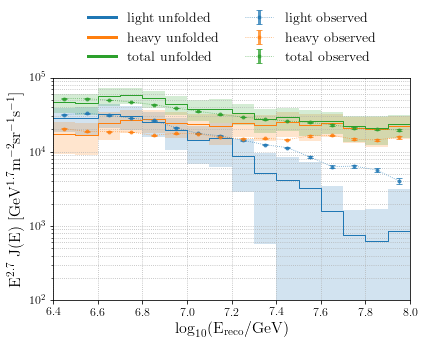

In [92]:
# Plot fraction of events vs energy
fig, ax = plt.subplots()

# Plot observed flux
for composition in comp_list + ['total']:
    flux = df_flux['flux_obs_{}'.format(composition)]
    flux_err = df_flux['flux_obs_{}_err'.format(composition)]
    ax.errorbar(energybins.log_energy_midpoints, flux, yerr=flux_err,
                marker='.', ls=':', color=color_dict[composition], alpha=0.75, 
                label=composition + ' observed')
    
    
# Plot unfolded flux
for composition in comp_list + ['total']:
    flux = df_flux['flux_unf_{}'.format(composition)]
    flux_err = df_flux['flux_unf_{}_err'.format(composition)]
    plotting.plot_steps(energybins.log_energy_bins, flux, yerr=flux_err,
                        ax=ax, color=color_dict[composition], label=composition + ' unfolded')
    
# # Plot model flux
# for composition in comp_list + ['total']:
#     fluxmodel = Hoerandel5()
#     name = 'Hoerandel5'
#     for idx, ptype in enumerate(model_ptypes[name][composition]):
#         fluxes = fluxmodel(flux_energy_points, ptype)
#         if idx == 0: scaled_flux = flux_energy_points**2.7*fluxes
#         else: scaled_flux += flux_energy_points**2.7*fluxes
#     ax.plot(np.log10(flux_energy_points), scaled_flux,
#             ls=model_to_style[name], linewidth=1.5, marker='None',
#             color=color_dict[composition], alpha=0.75, 
#             label=name + ' ' + composition)    
    
    
ax.set_yscale("log", nonposy='clip')
ax.set_xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('$\mathrm{ E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
ax.set_ylim([10**2, 10**5])
ax.grid(linestyle='dotted', which="both")
    
# # Add 3-year scraped flux
# df_proton = pd.read_csv('3yearscraped/proton', sep='\t', header=None, names=['energy', 'flux'])
# df_helium = pd.read_csv('3yearscraped/helium', sep='\t', header=None, names=['energy', 'flux'])
# df_light = pd.DataFrame.from_dict({'energy': df_proton.energy, 
#                                   'flux': df_proton.flux + df_helium.flux})

# df_oxygen = pd.read_csv('3yearscraped/oxygen', sep='\t', header=None, names=['energy', 'flux'])
# df_iron = pd.read_csv('3yearscraped/iron', sep='\t', header=None, names=['energy', 'flux'])
# df_heavy = pd.DataFrame.from_dict({'energy': df_oxygen.energy, 
#                                   'flux': df_oxygen.flux + df_iron.flux})

# if comp_class:
#     ax.plot(np.log10(df_light.energy), df_light.flux, label='3 yr light',
#             marker='.', ls=':')
#     ax.plot(np.log10(df_heavy.energy), df_heavy.flux, label='3 yr heavy',
#             marker='.', ls=':')
#     ax.plot(np.log10(df_heavy.energy), df_heavy.flux+df_light.flux, label='3 yr total',
#             marker='.', ls=':')
# else:
#     ax.plot(np.log10(df_proton.energy), df_proton.flux, label='3 yr proton',
#             marker='.', ls=':')
#     ax.plot(np.log10(df_helium.energy), df_helium.flux, label='3 yr helium',
#             marker='.', ls=':', color=color_dict['He'])
#     ax.plot(np.log10(df_oxygen.energy), df_oxygen.flux, label='3 yr oxygen',
#             marker='.', ls=':', color=color_dict['O'])
#     ax.plot(np.log10(df_iron.energy), df_iron.flux, label='3 yr iron',
#         marker='.', ls=':', color=color_dict['Fe'])
#     ax.plot(np.log10(df_iron.energy), df_proton.flux+df_helium.flux+df_oxygen.flux+df_iron.flux, label='3 yr total',
#     marker='.', ls=':', color='C2')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.35),# vertical 
          ncol=len(comp_list), fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

# plt.savefig('/home/jbourbeau/public_html/figures/spectrum.png')
# plt.savefig('/home/jbourbeau/public_html/figures/spectrum-3year-comparison.png')
flux_comparison_outfile = os.path.join(comp.paths.figures_dir, 'unfolding', 'iter-bayesian', 
                                       'flux_comparison_{}.png'.format(model_name))
comp.check_output_dir(flux_comparison_outfile)
plt.savefig(flux_comparison_outfile)

plt.show()

## Unfolding
[ [back to top](#top) ]

In [96]:
from icecube.weighting.fluxes import GaisserH3a, GaisserH4a, Hoerandel5
from icecube.weighting.weighting import ParticleType, PDGCode

In [12]:
PDGCode.values

{-16: NuTauBar,
 -14: NuMuBar,
 -12: NuEBar,
 12: NuE,
 14: NuMu,
 16: NuTau,
 2212: PPlus,
 1000020040: He4Nucleus,
 1000070140: N14Nucleus,
 1000080160: O16Nucleus,
 1000130270: Al27Nucleus,
 1000260560: Fe56Nucleus}

In [13]:
unfolding_df = pd.read_csv('unfolding/unfolding-dataframe.csv')

In [14]:
priors_list = ['h3a', 'antih3a', 'h4a', 'Hoerandel5', 'antiHoerandel5', 'uniform', 'alllight', 'allheavy']

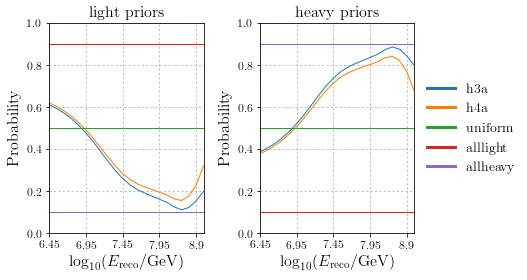

In [15]:
# with plt.rc_context({'text.usetex': False}):
fig, axarr = plt.subplots(1, 2, sharex=True)
for composition, ax in zip(comp_list, axarr.flat):
    for prior in priors_list:
        if 'Hoerandel5' in prior: continue
        if 'anti' in prior: continue
        unfolding_df['{}_priors_{}'.format(prior, composition)].plot(ax=ax,
                            marker='None', linestyle='-', linewidth=1, label='{}'.format(prior))
    ax.grid()
    ax.set_ylim([0, 1])
    ax.set_title(composition+' priors')
    ax.set_ylabel('Probability')
    ax.set_xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
    plt.xticks(np.arange(0, len(energybins.log_energy_midpoints), 5), energybins.log_energy_midpoints[::5])
leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.savefig('/home/jbourbeau/public_html/figures/priors.png')
plt.show()

In [97]:
comp_to_ptype = {'P': 2212, 'He': 1000020040, 'O':1000080160, 'Fe': 1000260560}

In [101]:
model_ptypes = {}
model_ptypes['h3a'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}
model_ptypes['h3a']['total'] = model_ptypes['h3a']['light'] + model_ptypes['h3a']['heavy']

model_ptypes['h4a'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}
model_ptypes['h4a']['total'] = model_ptypes['h4a']['light'] + model_ptypes['h4a']['heavy']

model_ptypes['Hoerandel5'] = {'light': [2212, 1000020040], 'heavy': [1000070140, 1000130270, 1000260560]}
model_ptypes['Hoerandel5']['total'] = model_ptypes['Hoerandel5']['light'] + model_ptypes['Hoerandel5']['heavy']

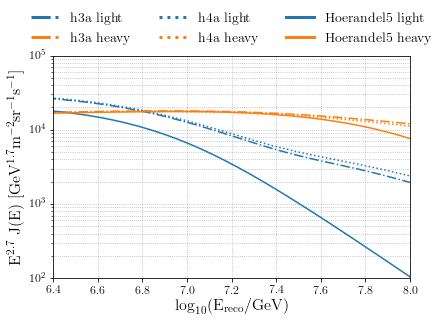

In [99]:
flux_energy_points = np.logspace(1, 15, 500)
model_to_style = {'h3a': '-.', 'h4a': ':', 'Hoerandel5': '-'}

fig, ax = plt.subplots()
# # Plot data
# for composition in comp_list + ['total']:
#     plotting.plot_steps(energybins.log_energy_bins, flux[composition], yerr=flux_err[composition],
#                         ax=ax, color=color_dict[composition], label=composition + ' (data)')
# for composition in comp_list:
for fluxmodel, name in zip([GaisserH3a(), GaisserH4a(), Hoerandel5()], ['h3a', 'h4a', 'Hoerandel5']): 
    for composition in comp_list:
#         if 'Hoerandel5' in name: continue
        for idx, ptype in enumerate(model_ptypes[name][composition]):
            fluxes = fluxmodel(flux_energy_points, ptype)
            if idx == 0: scaled_flux = flux_energy_points**2.7*fluxes
            else: scaled_flux += flux_energy_points**2.7*fluxes
        ax.plot(np.log10(flux_energy_points), scaled_flux,
                ls=model_to_style[name], linewidth=1.5, marker='None',
                color=color_dict[composition], label=name + ' ' + composition)    
            
            
ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\mathrm{\log_{10}(E_{reco}/GeV)}$')
ax.set_ylabel('$\mathrm{E^{2.7} \ J(E) \ [GeV^{1.7} m^{-2} sr^{-1} s^{-1}]}$')
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
# ax.set_xlim([3, 15])
ax.set_ylim([10**2, 10**5])
ax.grid(linestyle='dotted', which="both")

leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.25),# vertical 
          ncol=3, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

# plt.savefig('/home/jbourbeau/public_html/figures/prior-flux.png')
plt.show()

In [24]:
counts_priors = {}
counts_err_priors = {}
counts_light_upper_array = []
counts_light_lower_array = []
# counts_heavy_array = []
for priors in priors_list:
    _, _, counts, counts_err = comp.get1d('unfolding/PyUnfold/unfolded_output_{}.root'.format(priors),
                                          'NC', 'Unf_ks_ACM/bin0')
    counts_priors[priors] = {'light': counts[::2], 'heavy': counts[1::2]}
    counts_err_priors[priors] = {'light': counts_err[::2], 'heavy': counts_err[1::2]}
    counts_light_upper_array.append(counts_priors[priors]['light'] + counts_err_priors[priors]['light'])
    counts_light_lower_array.append(counts_priors[priors]['light'] - counts_err_priors[priors]['light'])
#     counts_heavy_array.append(counts_priors[priors]['heavy'])

In [56]:
np.amax(counts_light_upper_array, axis=0)

array([  4.67133264e+05,   3.30144905e+05,   2.09807067e+05,
         1.31081706e+05,   8.48194055e+04,   5.01570371e+04,
         3.18587174e+04,   1.87167833e+04,   1.22230989e+04,
         8.24971807e+03,   5.47707283e+03,   3.66599290e+03,
         2.54065644e+03,   1.67987062e+03,   1.15344026e+03,
         8.03034307e+02,   4.94624703e+02,   5.56816001e+02,
         1.67023771e+02,   6.42655879e+01,   3.07319852e+01,
         1.79585408e+01])

In [57]:
np.amax(counts_light_lower_array, axis=0)

array([  4.43520611e+05,   3.13188533e+05,   1.98775245e+05,
         1.24404904e+05,   8.03726102e+04,   4.88723067e+04,
         3.09150209e+04,   1.79396230e+04,   1.16446687e+04,
         7.86073310e+03,   5.17559025e+03,   3.46041920e+03,
         2.39355938e+03,   1.57637767e+03,   1.09222674e+03,
         7.58824214e+02,   4.59668204e+02,   5.18218057e+02,
         1.46907015e+02,   5.27349919e+01,   2.12784480e+01,
         1.09341975e+01])

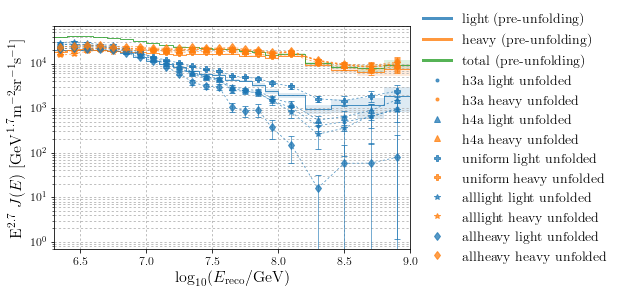

In [50]:
from matplotlib import container

fig, ax = plt.subplots()
model_markers = {'h3a': '.', 'antih3a': 'h', 'h4a': '^', 'Hoerandel5': 'o', 'antiHoerandel5': 's',
                 'uniform': 'P', 'alllight': '*', 'allheavy': 'd'}
for composition in comp_list + ['total']:
    plotting.plot_steps(energybins.log_energy_bins, flux[composition], yerr=flux_err[composition],
                        ax=ax, color=color_dict[composition], label=composition + ' (pre-unfolding)')

for prior in priors_list:
    if 'Hoerandel5' in prior: continue
    if 'anti' in prior: continue
    for composition in comp_list:
        
        unfolded_flux, unfolded_flux_err = comp.analysis.get_flux(counts_priors[prior][composition],
                                                        counts_err_priors[prior][composition],
                                                        energybins=energybins.energy_bins,
                                                        livetime=livetime)
        ax.errorbar(energybins.log_energy_midpoints, unfolded_flux, yerr=unfolded_flux_err,
                    ls=':', marker=model_markers[prior], color=color_dict[composition],
                    label='{} {} unfolded'.format(prior, composition), alpha=0.75)

ax.set_yscale("log", nonposy='clip')
ax.set_xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{E}^{2.7} \ J(E) \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
# ax.set_xlim([energybins.log_energy_min, 7.5])
# ax.set_ylim([5e3, 6e4])
# ax.set_ylim([10**-1, 10**5])
ax.grid(linestyle='dotted', which="both")

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]

leg = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5),
                 frameon=False, fancybox=False, numpoints=1)

# set the linewidth of each legend object
leg_first = leg.legendHandles[0]
leg_last = leg.legendHandles[-1]

for legobj in leg.legendHandles:
    if 'pre' in legobj.get_label():
        legobj.set_linewidth(3.0)
    else:
        legobj.set_linewidth(0.0)

plt.savefig('/home/jbourbeau/public_html/figures/spectrum-unfolded.png')
plt.show()

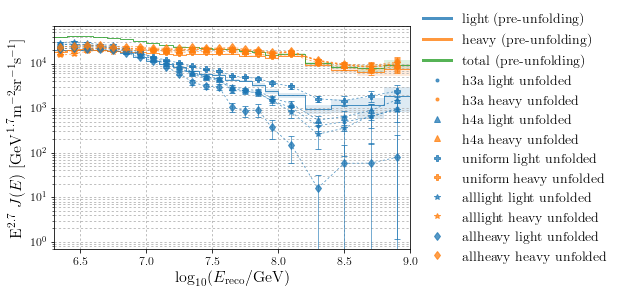

In [50]:
from matplotlib import container

fig, ax = plt.subplots()
model_markers = {'h3a': '.', 'antih3a': 'h', 'h4a': '^', 'Hoerandel5': 'o', 'antiHoerandel5': 's',
                 'uniform': 'P', 'alllight': '*', 'allheavy': 'd'}
for composition in comp_list + ['total']:
    plotting.plot_steps(energybins.log_energy_bins, flux[composition], yerr=flux_err[composition],
                        ax=ax, color=color_dict[composition], label=composition + ' (pre-unfolding)')

for prior in priors_list:
    if 'Hoerandel5' in prior: continue
    if 'anti' in prior: continue
    for composition in comp_list:
        unfolded_flux, unfolded_flux_err = comp.analysis.get_flux(counts_priors[prior][composition],
                                                        counts_err_priors[prior][composition],
                                                        energybins=energybins.energy_bins,
                                                        livetime=livetime)
        ax.errorbar(energybins.log_energy_midpoints, unfolded_flux, yerr=unfolded_flux_err,
                    ls=':', marker=model_markers[prior], color=color_dict[composition],
                    label='{} {} unfolded'.format(prior, composition), alpha=0.75)

ax.set_yscale("log", nonposy='clip')
ax.set_xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('$\mathrm{E}^{2.7} \ J(E) \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
# ax.set_xlim([energybins.log_energy_min, 7.5])
# ax.set_ylim([5e3, 6e4])
# ax.set_ylim([10**-1, 10**5])
ax.grid(linestyle='dotted', which="both")

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]

leg = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5),
                 frameon=False, fancybox=False, numpoints=1)

# set the linewidth of each legend object
leg_first = leg.legendHandles[0]
leg_last = leg.legendHandles[-1]

for legobj in leg.legendHandles:
    if 'pre' in legobj.get_label():
        legobj.set_linewidth(3.0)
    else:
        legobj.set_linewidth(0.0)

plt.savefig('/home/jbourbeau/public_html/figures/spectrum-unfolded.png')
plt.show()

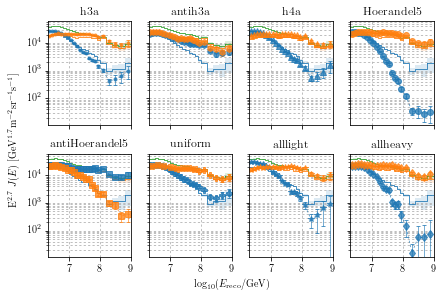

In [120]:
fig, axarr = plt.subplots(2, 4, sharex=True, sharey=True)
for prior, ax in zip(priors_list, axarr.flat):
    plotting.plot_steps(energybins.log_energy_bins, flux['total'], flux_err['total'], ax, color_dict['total'], 'total')
    for composition in comp_list:
        plotting.plot_steps(energybins.log_energy_bins, flux[composition], flux_err[composition], ax, color_dict[composition], composition)

        unfolded_flux, unfolded_flux_err = comp.analysis.get_flux(counts_priors[prior][composition],
                                                        counts_err_priors[prior][composition],
                                                        energybins=energybins.energy_bins,
                                                        livetime=livetime)
        ax.errorbar(energybins.log_energy_midpoints, unfolded_flux, yerr=unfolded_flux_err,
                    ls=':', marker=model_markers[prior], color=color_dict[composition],
                    label='{} {} unfolded'.format(prior, composition), alpha=0.75)

    ax.set_yscale("log", nonposy='clip')
    ax.set_title(prior)
#     ax.set_xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
#     ax.set_ylabel('$\mathrm{E}^{2.7} \ J(E) \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
    ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
    # ax.set_ylim([10**2, 10**5])
    ax.grid(linestyle='dotted', which="both")
    
fig.text(0.5, -0.02, '$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$', ha='center')
fig.text(-0.02, 0.5, '$\mathrm{E}^{2.7} \ J(E) \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$', va='center', rotation='vertical')

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.tight_layout()
plt.savefig('/home/jbourbeau/public_html/figures/spectrum-unfolded-array.png')
plt.show()